In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
from scipy.optimize import curve_fit

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))

time = data[0,:] - 9.4068e8
solar = data[1,:]
earth = data[2,:]
rays = data[3,:]

def graph(array1, array2, start, num_points, step, plot_num):
    start = start * 10
    end = start + num_points * 10
    ax[plot_num].plot(array1[start:end:step], array2[start:end:step])

Text(0.5, 1.0, 'Time vs. Cosmic Rays')

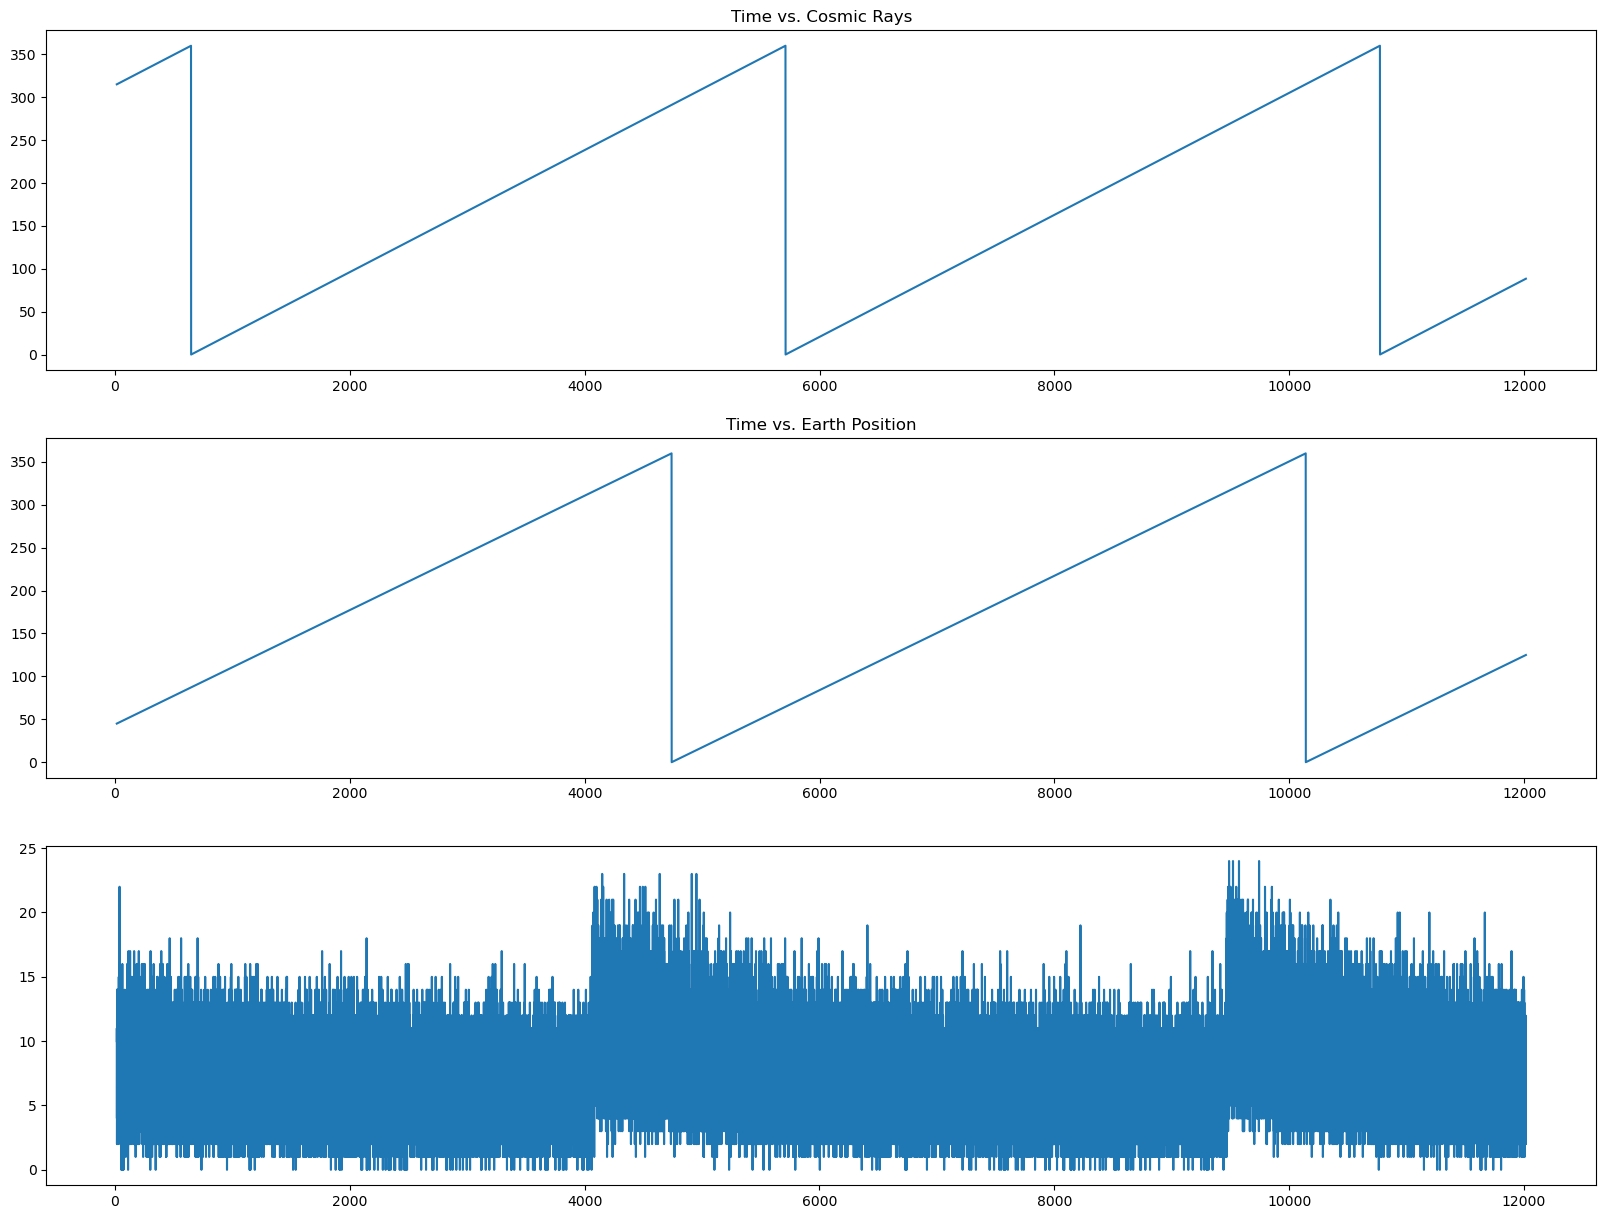

In [3]:
fig, ax = plt.subplots(3, 1, figsize = (20, 15))

graph(time, solar, 0, 12000, 10, 0)
ax[0].set_title("Time vs. Solar Position")

graph(time, earth, 0, 12000, 10, 1)
ax[1].set_title("Time vs. Earth Position")

graph(time, rays, 0, 12000, 1, 2)
ax[0].set_title("Time vs. Cosmic Rays")


Text(0.5, 1.0, 'Time vs. Gamma Rays')

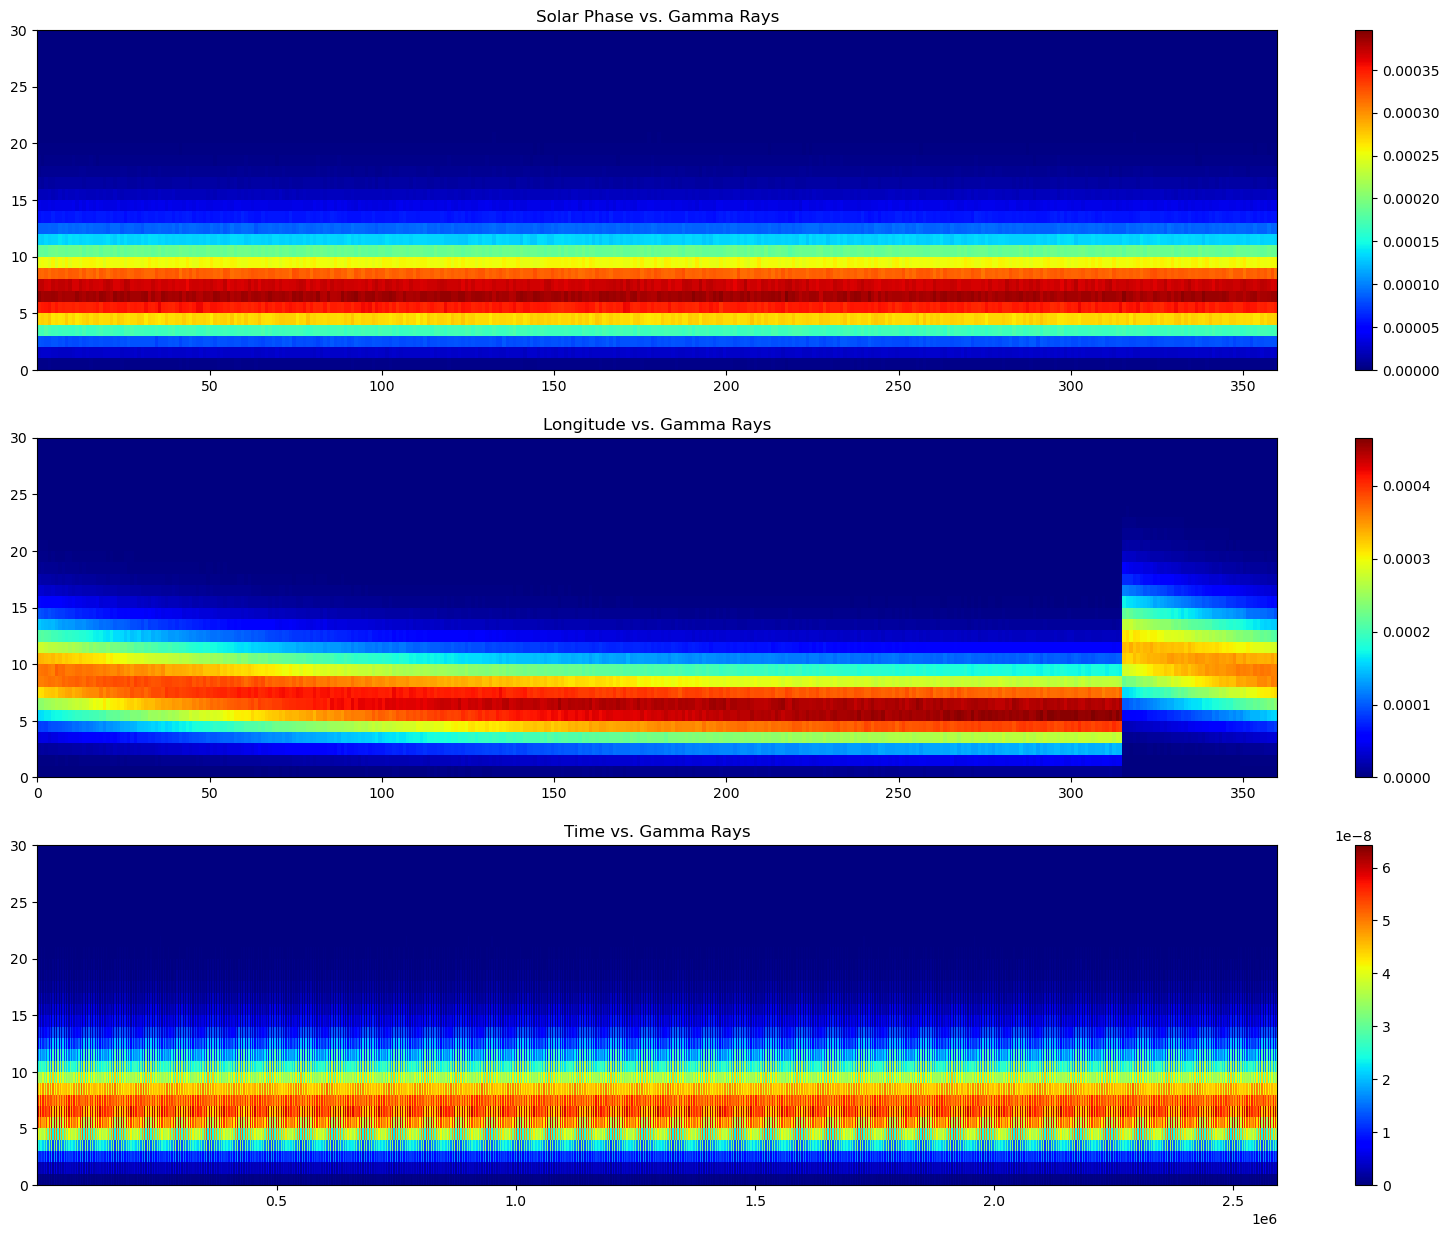

In [4]:
fig, ax = plt.subplots(3, 1, figsize = (20,15))

g = ax[0].hist2d(solar, rays, bins = [360,30], density = True, cmap = plt.cm.jet)
fig.colorbar(g[3], ax = ax[0])
ax[0].set_title("Solar Phase vs. Gamma Rays")

h = ax[1].hist2d(earth, rays, bins = [360,30], density = True, cmap = plt.cm.jet)
fig.colorbar(h[3], ax = ax[1])
ax[1].set_title("Longitude vs. Gamma Rays")

d = ax[2].hist2d(time, rays, bins = [1000,30], density = True, cmap = plt.cm.jet)
fig.colorbar(d[3], ax = ax[2])
ax[2].set_title("Time vs. Gamma Rays")

For background pdf we want f(d), where f gives the ray count as a function of degrees longitude. We know gamma rays normally follow a Poisson distribution, so we need a Poisson for each degree, which boils down to finding the mean gamma rays at each degree (or the mean as a function of degree). This is done from the 2D histogram for longitude. From here we can find d(t), where d gives the longitude at each time, and plug in for f(d(t)) to get f(t).

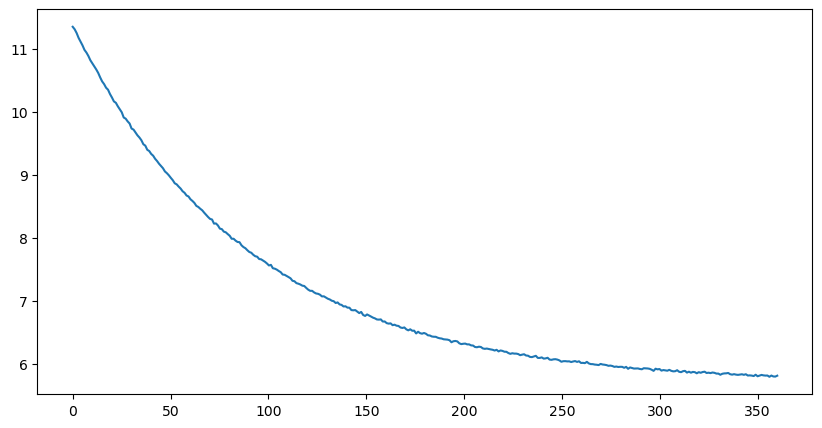

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (10,5))

# maxes = []
# for i in range(len(h[1]) - 1):
#     prob_index = np.argmax(h[0][i])
#     maxes.append(prob_index)
    
g = h

means = []
for i in range(len(g[1]) - 1):
    g[0][i] = g[0][i] / np.sum(g[0][i])
    av = 0
    for n in range(len(g[0][i]) - 1):
        av = av + (g[0][i][n] * n)
    means.append(av)

index = 0
for i in range(len(means) - 1):
    if(means[i] >= max(means)):
        index = i
        break

shifted_means = means[0:index]
for i in range(len(means) - index):
    shifted_means.insert(0, means[len(means) - (i + 1)])


ax.plot(np.linspace(0, 360, 360), shifted_means)

[ 6.0326141  -0.01109825  5.69951162  5.69829256]


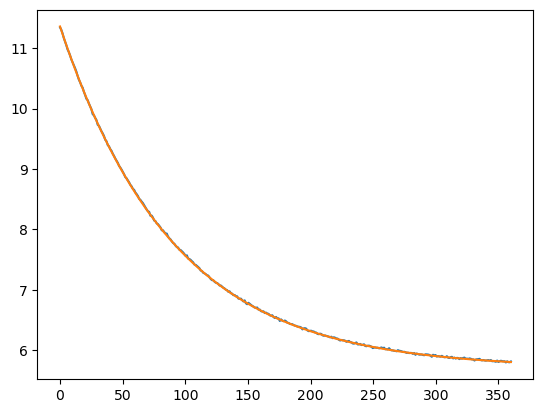

In [6]:
def fit(x, a, b, c, d):
    return a*np.exp(b*(x+c)) + d

guess_a = 5
guess_b = -0.01
guess_c = 15
guess_d = 6

init_guesses = [guess_a, guess_b, guess_c, guess_d]

fitpars, error = curve_fit(fit, np.arange(0, 360, 1), shifted_means, init_guesses)
print(fitpars)

fig, ax = plt.subplots(1, 1)

x = np.linspace(0, 360, 360)

f_x = fit(x, *fitpars)

def f_mean(x):
    return fitpars[0]*np.exp(fitpars[1]*(x+fitpars[2]))+fitpars[3]
    
ax.plot(x, shifted_means)
ax.plot(x, f_mean(x))

Average number of gamma-rays: $f(d) = 6.032e^{-0.01*(x + 5.70)} + 5.70$ for degree (d)

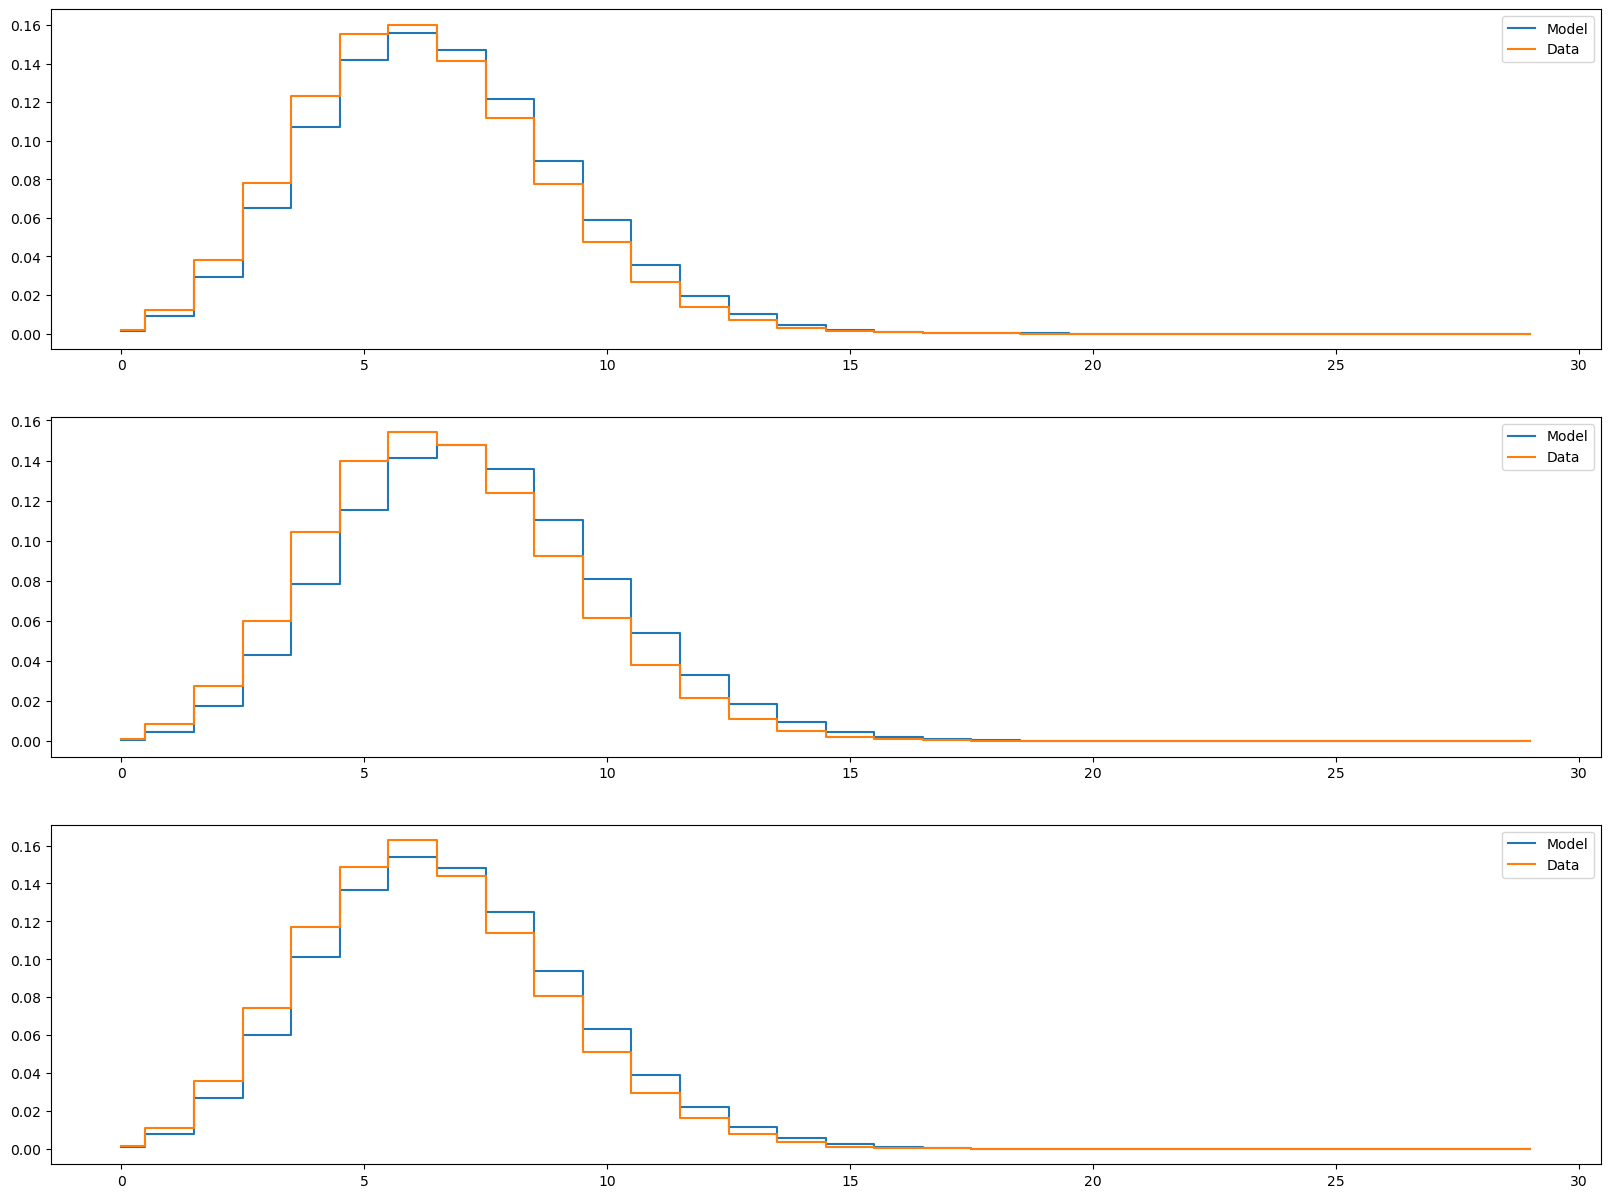

In [7]:
# Input a time (in seconds to the tenths place) to get the background model
# Starts at 0, not the actual GPS time


def time_to_deg(time):
    return int(earth[int(time * 10)])

def bkgd_model(time):
    return f_mean(earth[int(time * 10)])
    
mu = bkgd_model(4000.1)

fig, ax = plt.subplots(3, 1, figsize = (20,15))
x = np.arange(0, 30, 1)

ax[0].step(x, stats.poisson.pmf(x, bkgd_model(1800), loc = 0), where = 'mid')
ax[0].step(x, h[0][time_to_deg(1800)], where = 'mid')
ax[0].legend(["Model", "Data"])

ax[1].step(x, stats.poisson.pmf(x, bkgd_model(1000000), loc = 0), where = 'mid')
ax[1].step(x, h[0][time_to_deg(1000000)], where = 'mid')
ax[1].legend(["Model", "Data"])

ax[2].step(x, stats.poisson.pmf(x, bkgd_model(250000), loc = 0), where = 'mid')
ax[2].step(x, h[0][time_to_deg(250000)], where = 'mid')
ax[2].legend(["Model", "Data"])

# Problem 2

0


[[1, 126, 0],
 [1, 126, 1],
 [1, 126, 2],
 [1, 126, 3],
 [1, 126, 4],
 [1, 126, 5],
 [1, 126, 6],
 [1, 126, 7],
 [1, 126, 8],
 [1, 126, 9],
 [1, 189, 0],
 [1, 189, 1],
 [1, 189, 2],
 [1, 189, 3],
 [1, 189, 4],
 [1, 189, 5],
 [1, 189, 6],
 [1, 189, 7],
 [1, 189, 8],
 [1, 189, 9],
 [4, 105, 1],
 [4, 105, 3],
 [4, 105, 4],
 [7, 136, 0],
 [7, 136, 1],
 [7, 136, 2],
 [7, 136, 3],
 [7, 136, 4],
 [7, 136, 5],
 [7, 136, 6],
 [7, 136, 7],
 [7, 136, 8],
 [7, 136, 9],
 [8, 46, 2],
 [8, 46, 9],
 [9, 194, 0],
 [9, 194, 1],
 [9, 194, 2],
 [9, 194, 3],
 [9, 194, 4],
 [9, 194, 5],
 [9, 194, 6],
 [9, 194, 7],
 [9, 194, 8],
 [9, 194, 9],
 [10, 36, 0],
 [10, 36, 1],
 [10, 36, 2],
 [10, 36, 3],
 [10, 36, 4],
 [10, 36, 5],
 [10, 36, 6],
 [10, 36, 7],
 [10, 36, 8],
 [10, 36, 9],
 [13, 6, 0],
 [13, 6, 1],
 [13, 6, 2],
 [13, 6, 3],
 [13, 6, 4],
 [13, 6, 5],
 [13, 6, 6],
 [13, 6, 7],
 [13, 6, 8],
 [13, 6, 9],
 [14, 29, 0],
 [14, 29, 1],
 [14, 29, 2],
 [14, 29, 3],
 [14, 29, 4],
 [14, 29, 5],
 [14, 29, 6],
 [14

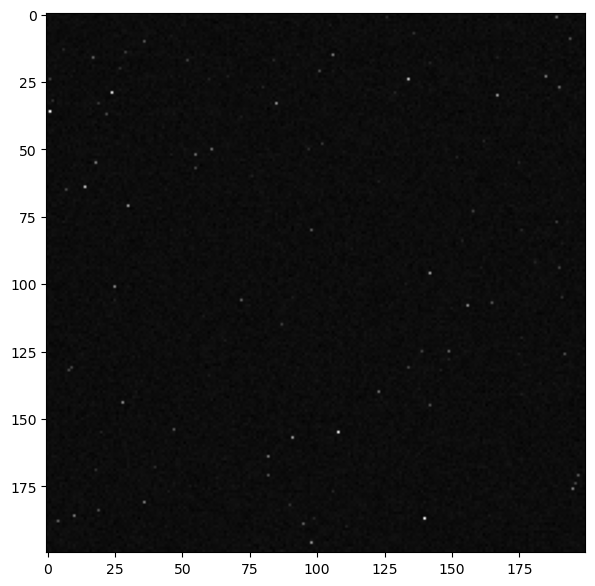

In [89]:
im = h5py.File('images.h5', 'r')
image1 = np.array(im.get('image1'))
imagestack = np.array(im.get('imagestack'))
# In Imagestack, the first index holds the y-value of the pixel, the second the x-index, the third the image (i.e. Imagestack[1][126][0] gives the 1st pixel from the top, 126th from the left,
# on the first image)

fig, ax = plt.subplots(1, 1, figsize = (7,7))
# ax.hist2d(image1,image1[0], bins = 200, density = False)

ax.imshow(imagestack[:,:,1], cmap = 'gray')

intensity = []
for i in range(len(imagestack[0][0])):
    intensity.append(imagestack[:,0,i])

avs = []
std = []
for i in range(len(intensity)):
    avs.append(np.sum(intensity[i]) / len(intensity[i]))
    std.append(scipy.stats.tstd(intensity[i]))


av_mean = np.sum(avs) / len(avs)
av_std = np.sum(std) / len(std)

bkgd_images = stats.norm.pdf(lin, loc = av_mean, scale = av_std)
prob5sigma = stats.norm.sf(5, loc = 0, scale = 1)
stat_sig = abs(stats.norm.ppf(prob5sigma, loc = av_mean, scale = av_std))

lin = np.linspace(-5, 5, 10000)
# ax[1].plot(lin, bkgd_images)

pixels = []
for i in range(len(imagestack[0])):
    for j in range(len(imagestack[0])):
        for n in range(len(imagestack[0][0])):
            if imagestack[i][j][n] >= stat_sig:
                pixels.append([i, j, n])

pixel_count = []
        

print(pixels[0][2])
pixels

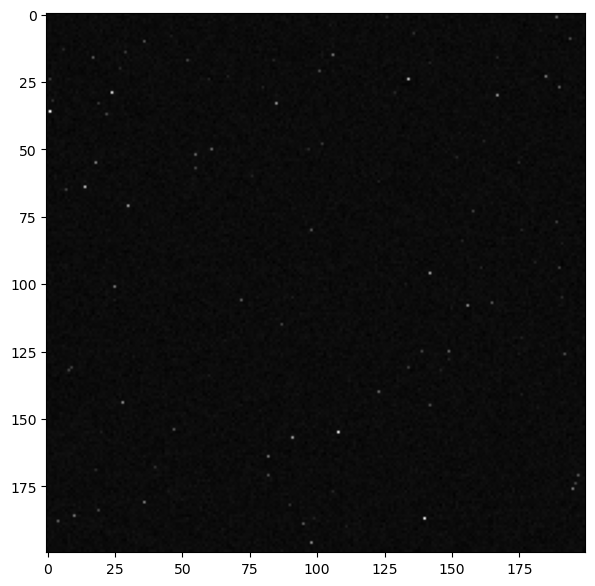

In [78]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

ax.imshow(imagestack[:,:,2], cmap = 'gray')

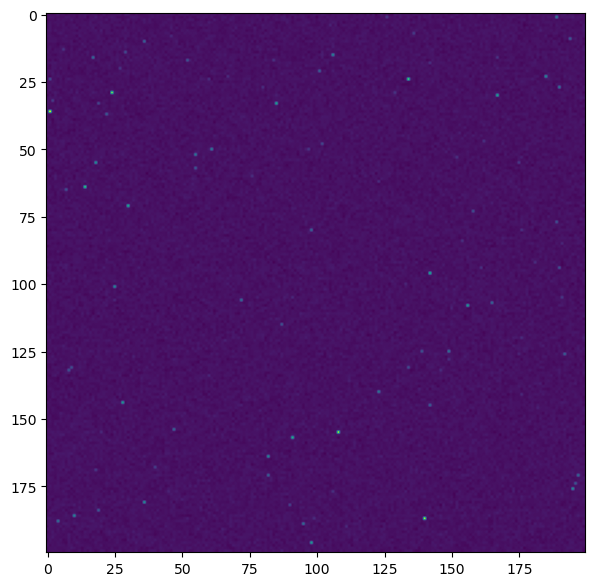

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

image_3 = []
for i in range(len(imagestack)):
    image_3.append([])
    for j in range(len(imagestack[i])):
        image_3[i].append(imagestack[i][j][2])

ax.imshow(image_3)

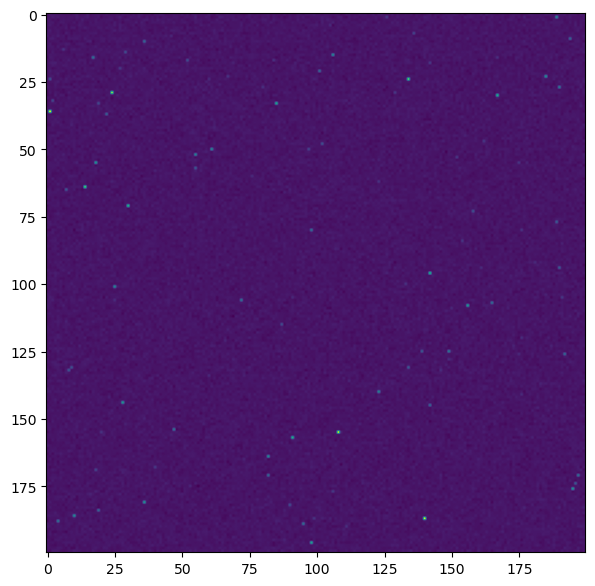

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

image_4 = []
for i in range(len(imagestack)):
    image_4.append([])
    for j in range(len(imagestack[i])):
        image_4[i].append(imagestack[i][j][3])

ax.imshow(image_4)

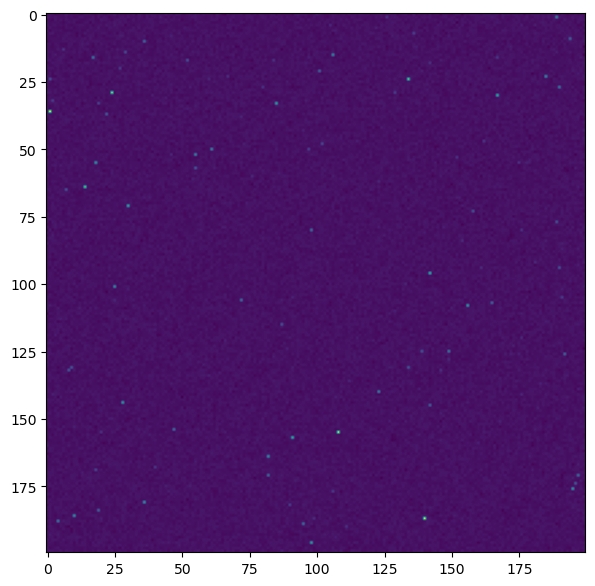

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

image_5 = []
for i in range(len(imagestack)):
    image_5.append([])
    for j in range(len(imagestack[i])):
        image_5[i].append(imagestack[i][j][4])

ax.imshow(image_5)

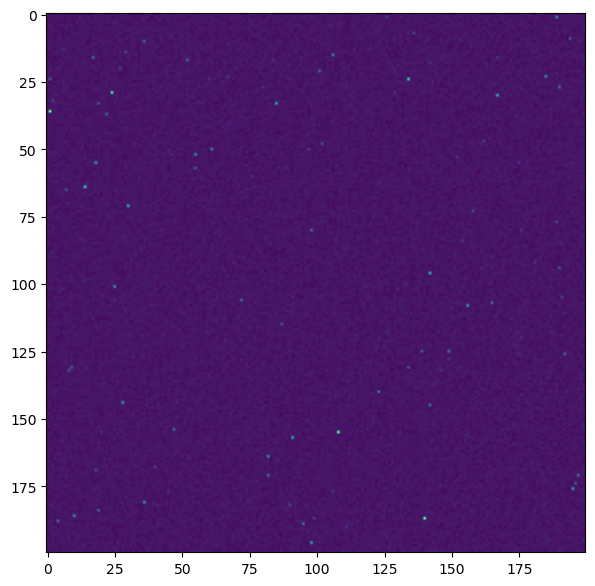

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

image_6 = []
for i in range(len(imagestack)):
    image_6.append([])
    for j in range(len(imagestack[i])):
        image_6[i].append(imagestack[i][j][5])

ax.imshow(image_6)

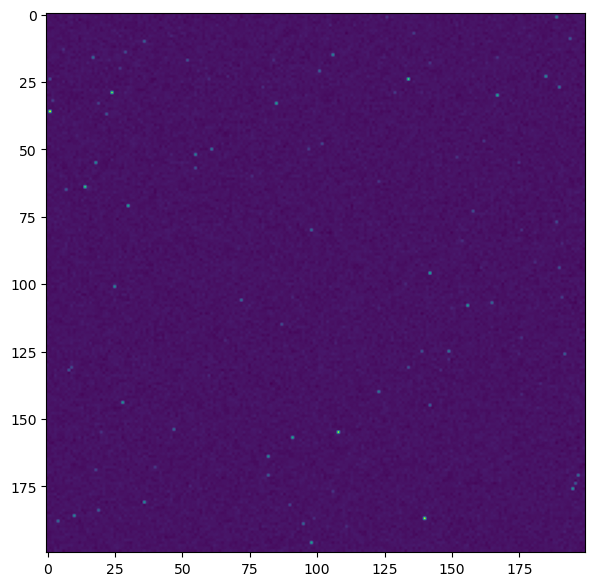

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

image_7 = []
for i in range(len(imagestack)):
    image_7.append([])
    for j in range(len(imagestack[i])):
        image_7[i].append(imagestack[i][j][6])

ax.imshow(image_7)

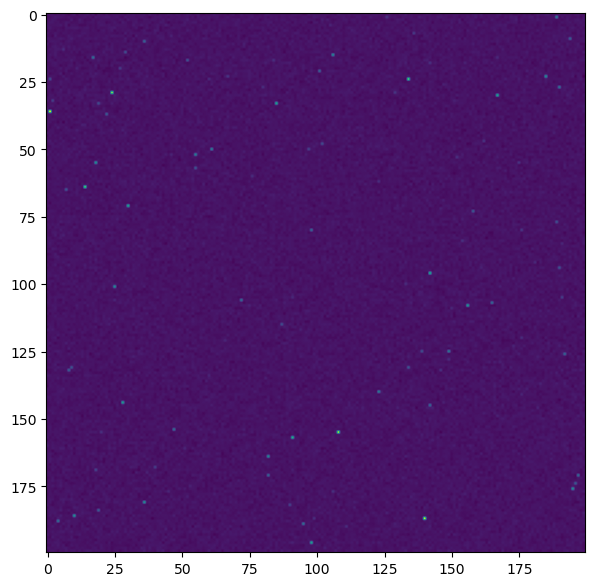

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

image_8 = []
for i in range(len(imagestack)):
    image_8.append([])
    for j in range(len(imagestack[i])):
        image_8[i].append(imagestack[i][j][7])

ax.imshow(image_8)

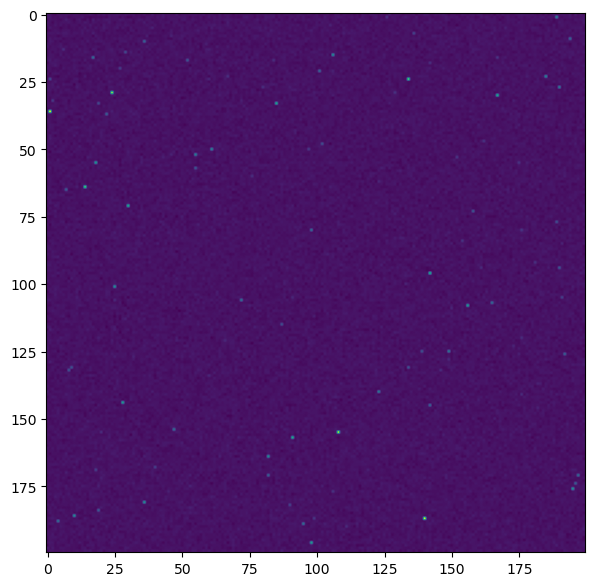

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

image_9 = []
for i in range(len(imagestack)):
    image_9.append([])
    for j in range(len(imagestack[i])):
        image_9[i].append(imagestack[i][j][8])

ax.imshow(image_9)

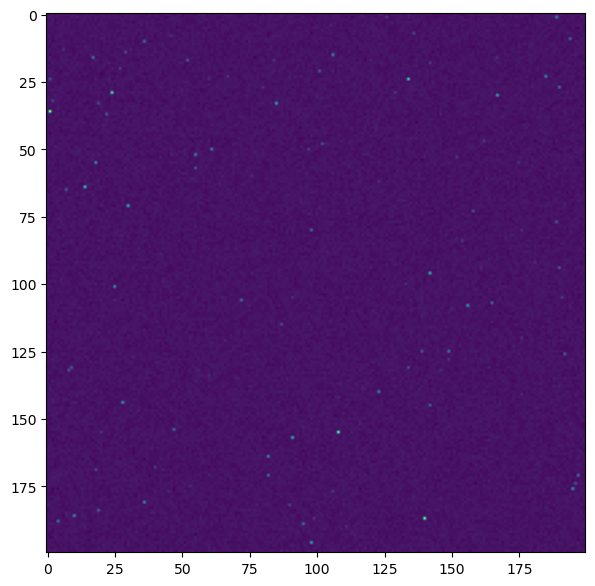

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

image_10 = []
for i in range(len(imagestack)):
    image_10.append([])
    for j in range(len(imagestack[i])):
        image_10[i].append(imagestack[i][j][9])

ax.imshow(image_10)

The background should be time independent and spatially consistent (the night sky does not change throughout time over the time the pictures were taken and is generally homogeneous).